In [1]:
from __future__ import print_function
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
import mixup_generator 
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
batch_size = 100
num_classes = 10
epochs = 150

In [3]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

training_generator = mixup_generator.MixupGenerator(x_train, y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

In [5]:
###########################################################
# Now this is necessary due to the feature normalization: #
datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

testdatagen.fit(x_train)
###########################################################

In [6]:
## DEF A BLOCK CONV + BN + GN + CONV + BN + GN + MAXPOOL 
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))

    
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))

  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [7]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 32, 32, 32)        0         
__________

In [8]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1,
                              patience=10, min_lr=0.005)

In [ ]:
## TRAINING with DA and LRA
history=model.fit_generator(generator=training_generator,
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=testdatagen.flow(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)

Epoch 1/150
500/500 [==============================] - 21s 43ms/step - loss: 2.0102 - acc: 0.2987 - val_loss: 1.6261 - val_acc: 0.4061
Epoch 2/150
500/500 [==============================] - 18s 36ms/step - loss: 1.5895 - acc: 0.4651 - val_loss: 1.2171 - val_acc: 0.5501
Epoch 3/150
500/500 [==============================] - 18s 36ms/step - loss: 1.4299 - acc: 0.5409 - val_loss: 1.1263 - val_acc: 0.6100
Epoch 4/150
500/500 [==============================] - 18s 37ms/step - loss: 1.3143 - acc: 0.5927 - val_loss: 1.0615 - val_acc: 0.6397
Epoch 5/150
500/500 [==============================] - 18s 36ms/step - loss: 1.2367 - acc: 0.6323 - val_loss: 1.0479 - val_acc: 0.6566
Epoch 6/150
500/500 [==============================] - 18s 36ms/step - loss: 1.1730 - acc: 0.6561 - val_loss: 0.8464 - val_acc: 0.7153
Epoch 7/150
500/500 [==============================] - 18s 37ms/step - loss: 1.1369 - acc: 0.6706 - val_loss: 1.1480 - val_acc: 0.6503
Epoch 8/150
500/500 [==============================] - 

In [11]:
score = model.evaluate_generator(testdatagen.flow(x_test, y_test,batch_size=batch_size), verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

100/100 [==============================] - 1s 10ms/step
Test loss: 0.3033847405016422
Test accuracy: 0.907500005364418


In [12]:
from keras.models import load_model

model.save('cnn9075.h5')

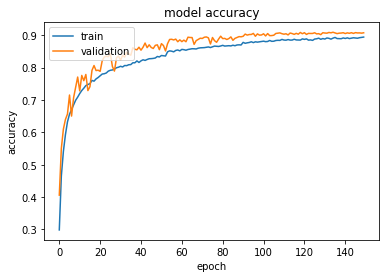

In [13]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('cnn9075.png')
plt.show()